In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

In [4]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [5]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence).encode('utf-8'))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

b'<start> may i borrow this book ? <end>'
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [7]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [8]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [9]:
def tokenize(text):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  tokenizer.fit_on_texts(text)

  input_sequences = tokenizer.texts_to_sequences(text)

  #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
  #                                                       padding='post')

  return input_sequences, tokenizer

In [10]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_sequences, inp_lang_tokenizer = tokenize(inp_lang)
  target_sequences, targ_lang_tokenizer = tokenize(targ_lang)

  return input_sequences, target_sequences, inp_lang_tokenizer, targ_lang_tokenizer

In [11]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_sequences, target_sequences, inp_lang_tokenizer, targ_lang_tokenizer = load_dataset(path_to_file, num_examples)


In [12]:
def convert(tokenizer, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, tokenizer.index_word[t]))

In [13]:
convert(inp_lang_tokenizer,input_sequences[0])

1 ----> <start>
135 ----> ve
3 ----> .
2 ----> <end>


In [14]:
convert(targ_lang_tokenizer,target_sequences[0])

1 ----> <start>
36 ----> go
3 ----> .
2 ----> <end>


In [15]:
input_sequences_train, input_sequences_val, target_sequences_train, target_sequqnces_val \
    = train_test_split(input_sequences, target_sequences, test_size=0.2)


In [16]:
train_dataset = tf.data.Dataset.from_generator(lambda: zip(input_sequences_train,target_sequences_train),
                                         output_types=(tf.int32,tf.int32), output_shapes=([None],[None]))

val_dataset = tf.data.Dataset.from_generator(lambda: zip(input_sequences_val,target_sequqnces_val),
                                         output_types=(tf.int32,tf.int32), output_shapes=([None],[None]))

In [17]:
BUFFER_SIZE = len(input_sequences_train)
BATCH_SIZE=64
train_dataset=train_dataset.cache().repeat().shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
val_dataset=val_dataset.cache().repeat().shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)

In [18]:
steps_per_epoch = len(input_sequences_train)//BATCH_SIZE
steps_val = len(input_sequences_val)//BATCH_SIZE
embedding_dim = 256
hidden_units_rnn = 1024
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

#dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
#dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [21]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 9]), TensorShape([64, 9]))

In [ ]:
import tensorflow

In [138]:
tf.random.set_seed(42)
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super().__init__()
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,mask_zero=True)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden=None):
    x = self.embedding(x)
    output, state = self.gru(x,initial_state = hidden)
    return output, state



In [139]:
encoder = Encoder(vocab_inp_size, embedding_dim, 4)


In [140]:
# sample input
sample_output, sample_hidden = encoder(example_input_batch)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 9, 4)
Encoder Hidden state shape: (batch size, units) (64, 4)


In [141]:
example_input_batch[:5]

<tf.Tensor: shape=(5, 9), dtype=int32, numpy=
array([[   1,  352,  120,    3,    2,    0,    0,    0,    0],
       [   1,    6,   16,  120,    5,    2,    0,    0,    0],
       [   1,   23, 2075,   21, 1605,    3,    2,    0,    0],
       [   1,    6,   46,   47,  269,    5,    2,    0,    0],
       [   1,   99, 1159,    3,    2,    0,    0,    0,    0]],
      dtype=int32)>

In [142]:
sample_output[0]

<tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[-2.5392290e-05,  3.6300298e-02,  7.0450734e-04,  2.2941139e-02],
       [ 2.2266373e-02,  1.3627531e-02, -5.8871116e-03,  8.0561247e-03],
       [ 2.7314935e-02, -2.9423306e-02,  2.4273315e-02, -7.4245860e-03],
       [ 1.3507830e-02, -3.0098576e-04,  4.0945407e-02,  2.7561266e-02],
       [ 1.9420188e-02,  3.2560918e-02,  3.6701716e-02,  2.4962708e-02],
       [ 1.9420188e-02,  3.2560918e-02,  3.6701716e-02,  2.4962708e-02],
       [ 1.9420188e-02,  3.2560918e-02,  3.6701716e-02,  2.4962708e-02],
       [ 1.9420188e-02,  3.2560918e-02,  3.6701716e-02,  2.4962708e-02],
       [ 1.9420188e-02,  3.2560918e-02,  3.6701716e-02,  2.4962708e-02]],
      dtype=float32)>

In [143]:
sample_hidden[0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.01942019, 0.03256092, 0.03670172, 0.02496271], dtype=float32)>

In [144]:
encoder.summary()

Model: "encoder_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     multiple                  2409984   
_________________________________________________________________
gru_25 (GRU)                 multiple                  3144      
Total params: 2,413,128
Trainable params: 2,413,128
Non-trainable params: 0
_________________________________________________________________


## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [145]:
from tensorflow import keras

In [146]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self,units):
        super().__init__()
        self.W1=keras.layers.Dense(units)
        self.W2=keras.layers.Dense(units)
        self.v=keras.layers.Dense(1)
        
    def call(self,query, values,inputs):
        """
        returns context vector and attention
        query is (batch_size, hidden_units_rnn) and is the input to RNN cell in decoder
        values is (batch_size, None, hidden_units_rnn) which is the output of encoder
        """
        mask=tf.expand_dims(tf.keras.backend.not_equal(inputs, 0),2)
        score = self.v(tf.nn.tanh(self.W1(tf.expand_dims(query,1))+self.W2(values))) # batch_size, None, 1
        score=score-tf.float32.max*tf.cast(tf.math.logical_not(mask),dtype=score.dtype)
        
        attention_weights = tf.nn.softmax(score,axis=1)
        
        context_vector = tf.reduce_sum(attention_weights*values,axis=1) # batch_size, hidden_units
        return context_vector,attention_weights
        

In [147]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output,example_input_batch )

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 4)
Attention weights shape: (batch_size, sequence_length, 1) (64, 9, 1)


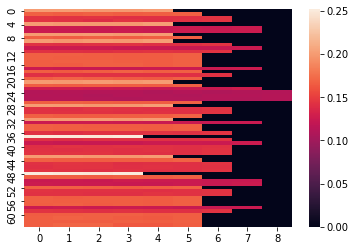

In [148]:
import seaborn as sns
sns.heatmap(attention_weights[:,:,0])

In [149]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, attention_units=None):
    super().__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc=keras.layers.Dense(vocab_size)
    if attention_units is None:
        self.attention_units=self.dec_units
    self.attention = BahdanauAttention(self.attention_units)

  def call(self, x, hidden, enc_output, enc_inp):
    # x comes in with (batch_size, 1)
    x = self.embedding(x)
    
    # x is (batch_size, 1, embedding_dim)
    
    context_vector, attention_weights = self.attention(hidden, enc_output,enc_inp)
    
    # context vector is (batch_size, attention_units)
    
    x=tf.concat([tf.expand_dims(context_vector,1),x],axis=2)
    
    # x is now (batch_size,1, attention_units+embedding_dims)
    
    output, state = self.gru(x)
    
    # output is (batch_size,1,hidden_units)
    
    output = tf.reshape(output, (-1, output.shape[2]))
    
    # output is (batch_size,hidden_units)
    
    x = self.fc(output)
    
    # x is (batch_size, vocab_size)
    
    return x,state,attention_weights

In [151]:
decoder = Decoder(10, embedding_dim, 4)

sample_decoder_output, _, aw = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output,example_input_batch)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 10)


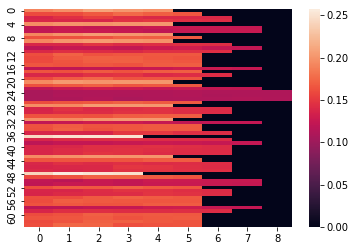

In [152]:
sns.heatmap(aw[:,:,0])

In [153]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [154]:
train_step_signature = [
    (tf.TensorSpec(shape=(BATCH_SIZE, None), dtype=tf.int32),
    tf.TensorSpec(shape=(BATCH_SIZE, None), dtype=tf.int32),)
]



class Seq2Seq(keras.models.Model):
    
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
    
    @tf.function(input_signature=train_step_signature)
    def train_step(self,data):
        #print('tracing_train_step')
        
        inp, targ = data
        
        loss=0.0
        all_predictions = tf.TensorArray(tf.float32,size=0,dynamic_size=True)
        
        with tf.GradientTape() as tape:
            enc_output,encoder_hidden_state = self.encoder(inp)
            dec_hidden = encoder_hidden_state
            dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
            
            
            # Teacher forcing - feeding the target as the next input
            for t in tf.range(1, tf.shape(targ)[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output,inp)

                loss+=self.compiled_loss(tf.cast(targ[:, t],tf.float32), predictions, regularization_losses=self.losses)
                
                dec_input = tf.expand_dims(targ[:, t], 1)
                all_predictions = all_predictions.write(all_predictions.size(),predictions)
                
        all_predictions=tf.transpose(all_predictions.stack(),[1,0,2])

        batch_loss = (loss / tf.cast(tf.shape(targ)[1],tf.float32))

        trainable_vars = self.encoder.trainable_variables + self.decoder.trainable_variables

        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        self.compiled_metrics.update_state(targ[:,1:], all_predictions)
        
        # Return a dict mapping metric names to current value
        
        result = {m.name: m.result() for m in self.metrics}
        result['loss'] = batch_loss
        return result

    
    @tf.function(input_signature=train_step_signature)
    def test_step(self,data):
        #print('tracing_test_step')
        
        inp, targ = data
        
        all_predictions=[]
        
        loss=0.0
        
        all_predictions = tf.TensorArray(tf.float32,size=0,dynamic_size=True)
        
        enc_output,encoder_hidden_state = self.encoder(inp)
        dec_hidden = encoder_hidden_state

        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)


        # Teacher forcing - feeding the target as the next input
        for t in tf.range(1, tf.shape(targ)[1]):

            # passing enc_output to the decoder
            predictions, dec_hidden, _ = self.decoder(dec_input, 
                                                      dec_hidden, 
                                                      enc_output,
                                                      inp)
            loss+=self.compiled_loss(tf.cast(targ[:, t],tf.float32), predictions, regularization_losses=self.losses)

            dec_input = tf.expand_dims(targ[:, t], 1)
            all_predictions = all_predictions.write(all_predictions.size(),predictions)
                
        all_predictions=tf.transpose(all_predictions.stack(),[1,0,2])
        batch_loss = (loss / tf.cast(tf.shape(targ)[1],tf.float32))

        self.compiled_metrics.update_state(targ[:,1:], all_predictions)
        result = {m.name: m.result() for m in self.metrics}
        result['loss'] = batch_loss
        return result


In [85]:
encoder = Encoder(vocab_inp_size, embedding_dim, hidden_units_rnn)
decoder = Decoder(vocab_tar_size, embedding_dim, hidden_units_rnn)

model=Seq2Seq(encoder,decoder)

In [86]:
model.compile(optimizer=optimizer,loss=loss_function,metrics=['accuracy'])

In [88]:
model.fit(train_dataset,validation_data=val_dataset,epochs=10,steps_per_epoch=steps_per_epoch,validation_steps=steps_val)

Epoch 1/10
  9/375 [..............................] - ETA: 3:23 - loss: 0.1842 - accuracy: 0.9533

KeyboardInterrupt: 

In [89]:
max_length_targ=20
max_length_inp=20

In [155]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  enc_out, enc_hidden = encoder(inputs)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out,inputs)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang_tokenizer.index_word[predicted_id] + ' '

    if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [156]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [160]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))
  return attention_plot

In [158]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [165]:
_,_,ap=evaluate(u'esta es mi vida.')

In [167]:
ap

array([[0.13698375, 0.14319932, 0.14700261, 0.14565113, 0.14316934,
        0.14256196, 0.1414319 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.13696811, 0.14318967, 0.14702344, 0.14566462, 0.14316931,
        0.14255986, 0.14142506, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.13696811, 0.14318967, 0.14702344, 0.14566462, 0.14316931,
        0.14255986, 0.14142506, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.13696811, 0.14318967, 0.14702344, 0.14566462, 0.14316931,
        0.14255986, 0.14142506, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s cold is cold here . <end> 


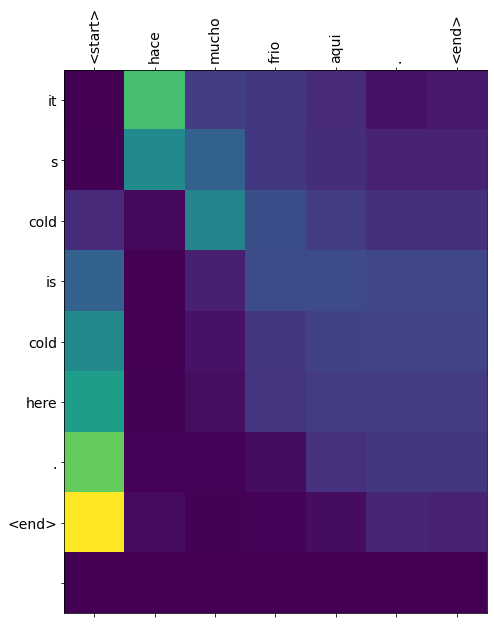

In [100]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


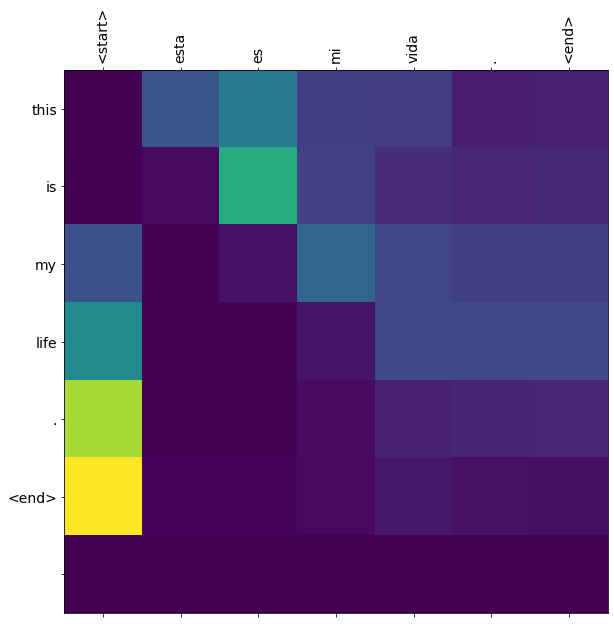

In [101]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


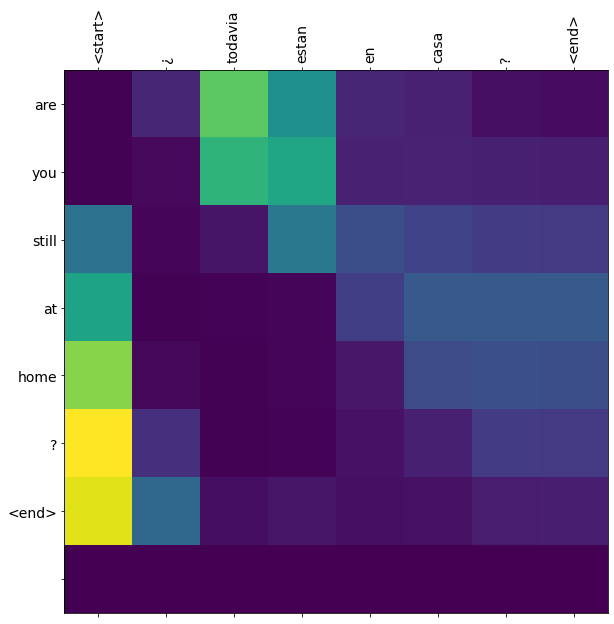

In [102]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


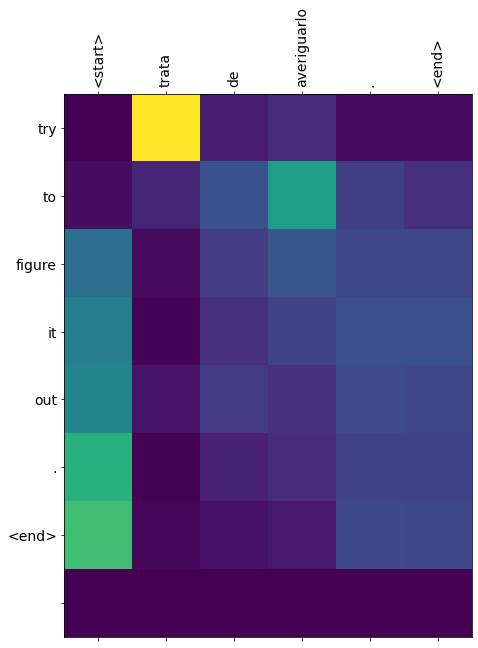

In [103]:
# wrong translation
translate(u'trata de averiguarlo.')